### Setup & Definition

In [1]:
import torch
import random
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#deallocate all cuda memory
torch.cuda.empty_cache()

#print cuda memory
print(torch.cuda.memory_allocated())

cuda
0


In [2]:
def positional_encoding(x, dim: int = 48):
    """
    Binary positional encoding, where each dimension is a bit in the binary representation of the index.
    
    Args:
        x: Input tensor of positions with shape [N]
        dim (int): Number of bits in the binary encoding (output dimension). Default is 48.

    Returns:
        torch.Tensor: A binary encoding tensor with shape [N, dim] where each bit represents a binary position.
    """

    # Each row corresponds to an element in x; columns are the binary bits
    encoding = ((x.unsqueeze(1) >> torch.arange(dim, device=x.device)) & 1).to(torch.float32)

    return encoding

In [3]:
class AUNNModel(nn.Module):
    def __init__(self, embedding_dim:int, output_dim:int, num_layers:int, hidden_dim:int):

        super(AUNNModel, self).__init__()
        
        assert num_layers % 2 == 0 and num_layers >= 2, "Number of layers must be even and at least 2."

        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Input Layer
        self.input_layer = nn.Sequential(
            nn.Linear(self.embedding_dim, self.hidden_dim),
            nn.SiLU()
        )

        # Hidden Layers
        self.layers = nn.ModuleList()
        for _ in range(self.num_layers - 2):  # Exclude input and output layers
            self.layers.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.SiLU()
            ))

        # Output Layer
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        
        output = self.input_layer(x)
        residual = output  # Initialize residual for skip connections

        for idx, layer in enumerate(self.layers):
            output = layer(output)

            # Apply skip connection every two layers
            if (idx + 1) % 2 == 0:
                output = output + residual  # Skip connection
                residual = output  # Update residual

        output = self.output_layer(output)
        return output

In [4]:
# Define a function to save the model checkpoint
def save_checkpoint(model, params, optimizer, losses, filename="checkpoint.pth"):
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
    }

    keys = ['embedding_dim', 'output_dim', 'num_layers', 'hidden_dim']
    assert all(k in params for k in keys)
    for k in keys:
        checkpoint[k] = params[k]

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved with loss {losses[-1]:.4f}")

In [5]:
def load_checkpoint(filename="checkpoint.pth"):

    checkpoint = torch.load(filename, weights_only=True)
    
    keys = ['embedding_dim', 'output_dim', 'num_layers', 'hidden_dim']
    params = {k: checkpoint[k] for k in keys}
    
    model = AUNNModel(**params)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    losses = checkpoint['losses']

    print(f"Checkpoint loaded: loss {losses[-1]:.4f}")

    return model, optimizer, losses

### Train

In [6]:
# Hyperparameters

embedd_dim = 64
num_layers = 4     # Must be even and at least 2 (bc of skip connections)
hidden_dim = 128   # Size of hidden layers
batch_size = 8192  # Adjust batch size for efficiency
num_epochs = 500

In [7]:
#really long repeated pattern
'''
text = "abc" * 10_000  # Repeat the sequence to create a long string
'''

#really long random pattern
options = ['|aaa','|bbb','|ccc']
num_sequences = 15_000
num_repeats = num_sequences * len(options)
num_repeats = num_repeats - num_repeats % batch_size # ensure num_repeats is a multiple of batch_size
options = options * num_repeats
random.seed(42)
random.shuffle(options)
text = ''.join(options)
print(len(text))

491520


In [8]:
vocab = sorted(set(text))
token_to_id = {token: id for id, token in enumerate(vocab)}
id_to_token = {id: token for token, id in token_to_id.items()}
token_ids = [token_to_id[char] for char in text]
token_ids = torch.tensor(token_ids, dtype=torch.long).to(device)
indices = torch.arange(len(token_ids))
embeds = positional_encoding(indices, embedd_dim).to(device)

In [9]:
# Initialize the model, loss function, and optimizer
model = AUNNModel(embedd_dim, len(vocab), num_layers, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

In [10]:
# Training Loop
losses = []
accuracies = []
total_steps = len(text) // batch_size
if len(text) % batch_size != 0:
    total_steps += 1

for epoch in tqdm(range(num_epochs)):
    model.train()
    start_idxs = list(range(0, len(text), batch_size))
    # random.seed(epoch)
    # random.shuffle(start_idxs)
    for start_idx in start_idxs:
        end_idx = start_idx + batch_size
        
        inputs = embeds[start_idx:end_idx]
        targets = token_ids[start_idx:end_idx]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        cur_loss = loss.item()
        losses.append(cur_loss)

        #calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == targets).sum().item()
        cur_acc = correct / batch_size
        accuracies.append(cur_acc)
        

    avg_loss = sum(losses[-len(start_idxs):]) / len(start_idxs)
    avg_acc = sum(accuracies[-len(start_idxs):]) / len(start_idxs)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.6f}, Average Accuracy: {avg_acc:.4f}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500] completed, Average Loss: 1.060222, Average Accuracy: 0.4500
Epoch [2/500] completed, Average Loss: 0.844042, Average Accuracy: 0.5002
Epoch [3/500] completed, Average Loss: 0.841071, Average Accuracy: 0.5010
Epoch [4/500] completed, Average Loss: 0.836392, Average Accuracy: 0.5010
Epoch [5/500] completed, Average Loss: 0.828839, Average Accuracy: 0.4995
Epoch [6/500] completed, Average Loss: 0.829891, Average Accuracy: 0.5024
Epoch [7/500] completed, Average Loss: 0.826376, Average Accuracy: 0.5017
Epoch [8/500] completed, Average Loss: 0.826511, Average Accuracy: 0.5025
Epoch [9/500] completed, Average Loss: 0.825819, Average Accuracy: 0.5019
Epoch [10/500] completed, Average Loss: 0.826045, Average Accuracy: 0.5021
Epoch [11/500] completed, Average Loss: 0.825913, Average Accuracy: 0.5022
Epoch [12/500] completed, Average Loss: 0.825833, Average Accuracy: 0.5025
Epoch [13/500] completed, Average Loss: 0.825814, Average Accuracy: 0.5028
Epoch [14/500] completed, Average 

In [ ]:
params = {
    'embedding_dim': embedd_dim,
    'output_dim': len(vocab),
    'num_layers': num_layers,
    'hidden_dim': hidden_dim
}
save_checkpoint(model, params, optimizer, losses, filename="sequence/checkpoint.pth")

In [ ]:
model, optimizer, losses = load_checkpoint(filename="sequence/checkpoint.pth")

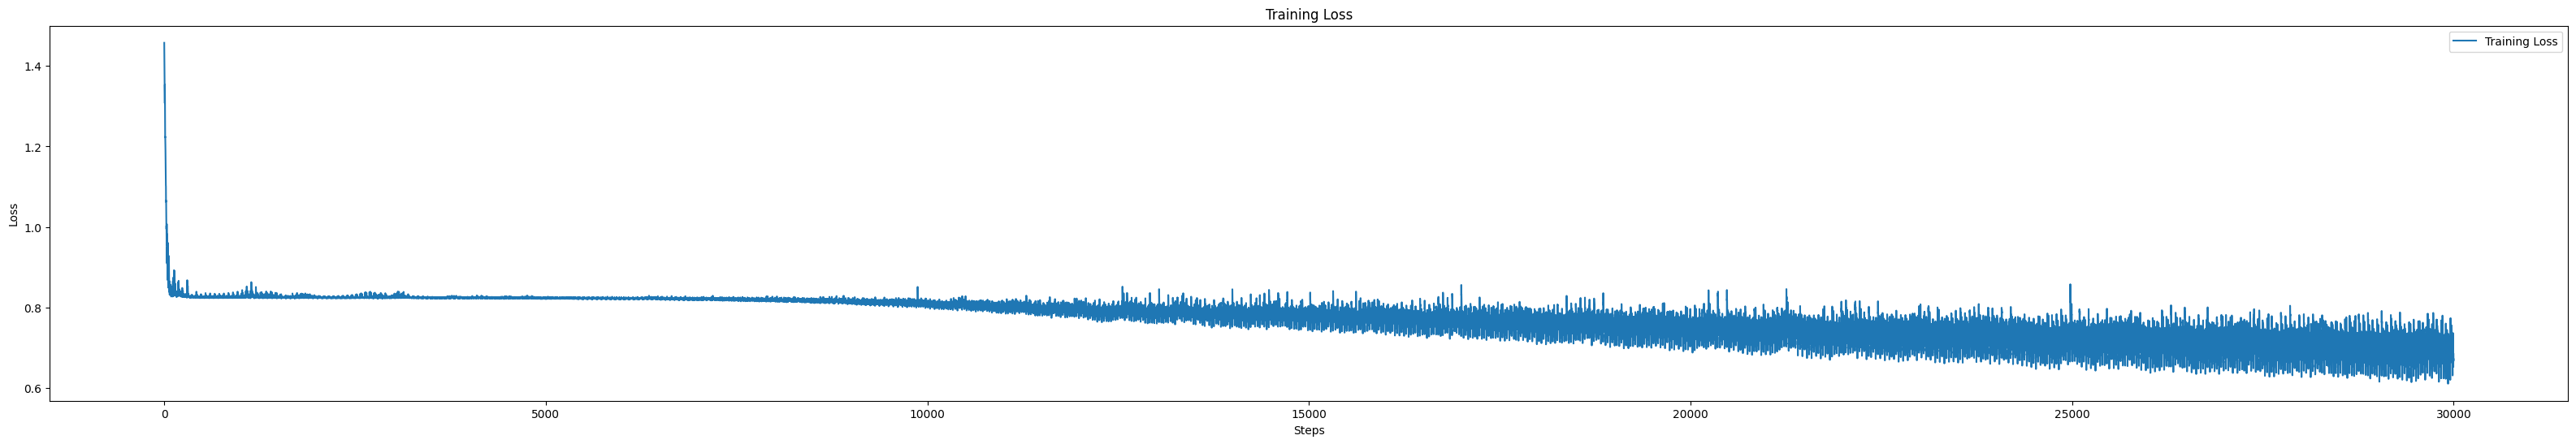

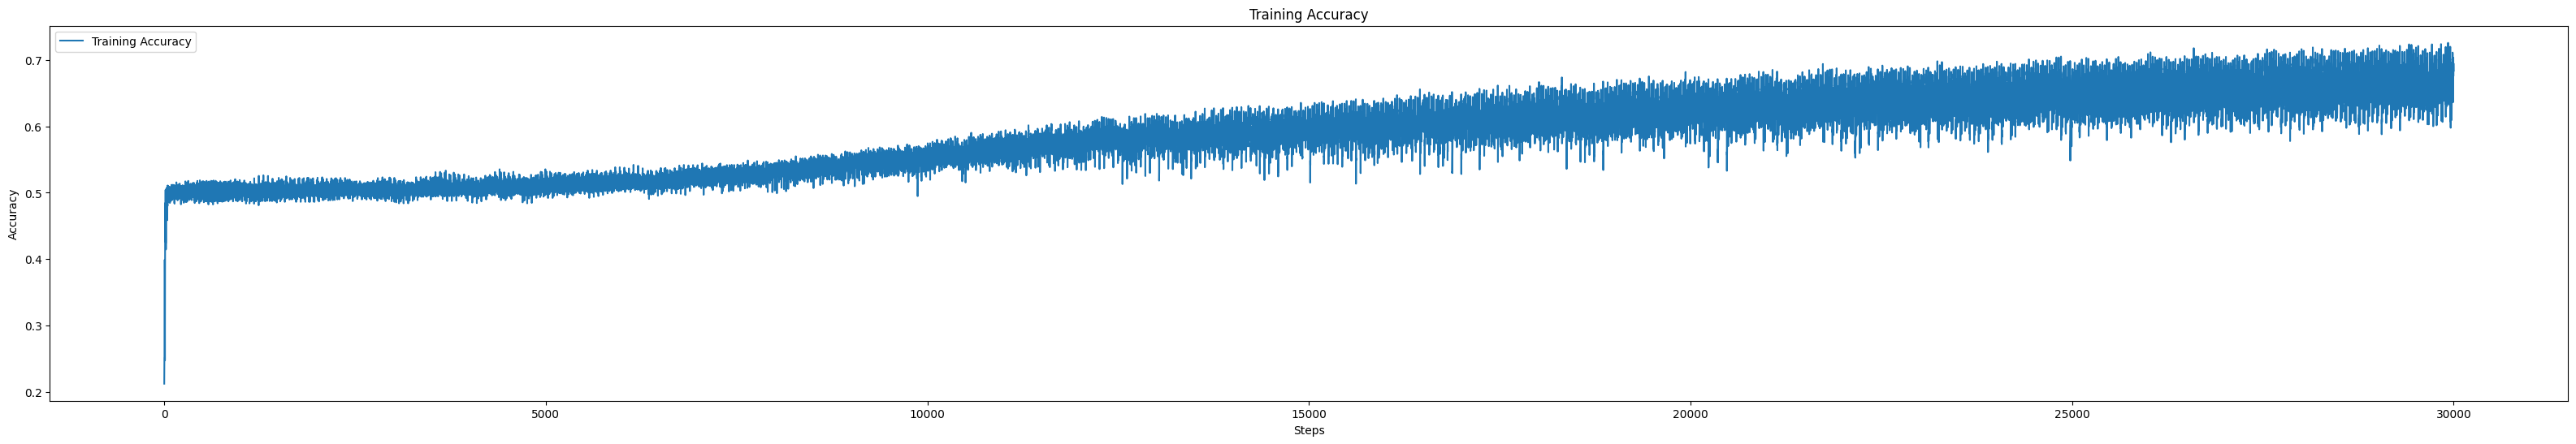

In [11]:
# Plot the loss curves
plt.figure(figsize=(40, 6))
plt.plot(losses[::], label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(40, 6))
plt.plot(accuracies[::], label="Training Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

In [12]:
# Generate Text Function
def generate_text(model, start_index, length):
    model.eval()
    generated_tokens = []
    indices = torch.arange(start_index, start_index + length)
    inputs = positional_encoding(indices, embedd_dim).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
    for id in predicted:
        token = id_to_token.get(id.item(), "<UNK>")
        generated_tokens.append(token)
    return ''.join(generated_tokens)

# Generate text starting from the next index after the training data
start_index = 0
generated_text = generate_text(model, start_index=start_index, length=100)
print("Generated Text:")
print(generated_text)

# Generate text starting from the next index after the training data
start_index = len(text)
generated_text = generate_text(model, start_index=start_index, length=100)
print("Generated Text:")
print(generated_text) #learns underlying pattern & generalizes to unseen indices :)

Generated Text:
|bbb|ccc|ccc|bbb|aaa|aaa|bbb|ccc|bbb|ccc|ccc|bbb|aaa|ccc|ccc|ccc|bbb|aaa|ccc|ccc|aaa|aaa|bbb|bbc|bbb
Generated Text:
|aaa|aaa|bbb|aaa|ccc|ccc|bbb|ccc|ccc|aaa|bbb|ccc|ccc|ccc|bbb|ccc|bbc|acc|bbb|bbb|aaa|aaa|caa|aaa|ccc


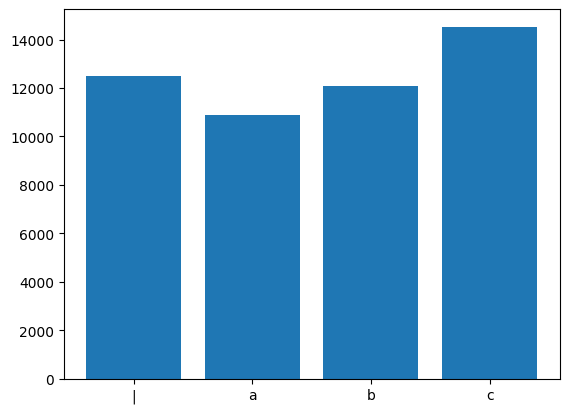

In [13]:
N = len(text) - 1
preds = generate_text(model, start_index=N+1, length=50_000)
count = {}
for char in preds:
    count[char] = count.get(char, 0) + 1

plt.bar(count.keys(), count.values())
plt.show()

In [ ]:
# Evaluate the accuracy of the model on the dataset via random sample of 100k characters
import random

# Number of samples
num_samples = 100_000

# Randomly select indices from the dataset
sample_indices = random.sample(range(len(text)), num_samples)

# Get positions and targets for the sampled indices
inputs = []
outputs = []
for idx in sample_indices:
    inp = embeds[idx]
    inputs.append(inp)
    output = token_ids[idx]
    outputs.append(output)

# Concatenate the inputs and outputs
inputs = torch.stack(inputs).to(device)
outputs = torch.stack(outputs).to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    predictions = model(inputs)
    _, predicted = torch.max(predictions, 1)
    
# Calculate accuracy
correct = (predicted == outputs).sum().item()
accuracy = correct / num_samples
print(f"Accuracy: {accuracy * 100:.2f}%")

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 41860


In [15]:
N = len(text) - 1

#see value before conditioning
generated_text = generate_text(model, start_index=N+1, length=150)
print("Original Text:")
print(generated_text) # "|a..."
print("")

#conditioning the model
conditioning_targets = ['|','c']  # Desired tokens at N+1 and N+2, this also works if you use "|b"
conditioning_positions = [N+1, N+2]
# conditioning_targets = ['c','a','b'] #show conditioning works on discontinuous tokens
# conditioning_positions = [N+2, N+7, N+12]

conditioning_target_indices = [token_to_id[token] for token in conditioning_targets]
targets_tensor = torch.tensor(conditioning_target_indices, dtype=torch.long).to(device)
positions_tensor = torch.tensor(conditioning_positions)
inputs = positional_encoding(positions_tensor, embedd_dim).to(device)

criterion = nn.CrossEntropyLoss()
conditioning_optimizer = optim.SGD(model.parameters(), lr=1e-3)
model.train()
num_conditioning_steps = 10

for step in range(num_conditioning_steps):
    conditioning_optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets_tensor)
    loss.backward()
    conditioning_optimizer.step()
    print(f"Conditioning Step {step+1}/{num_conditioning_steps}, Loss: {loss.item():.6f}")

#see value after conditioning
generated_text = generate_text(model, start_index=N+1, length=150)
print("")
print("Text after conditioning:")
print(generated_text) # "|ccc|..." shows conditioning works because of new values for N+3 and N+4

Original Text:
|aaa|aaa|bbb|aaa|ccc|ccc|bbb|ccc|ccc|aaa|bbb|ccc|ccc|ccc|bbb|ccc|bbc|acc|bbb|bbb|aaa|aaa|caa|aaa|ccc|bbb|bbb|ccc|bbb|bbb|bbb|bbb|aaa|ccc|ccc|ccc|aaa|c

Conditioning Step 1/10, Loss: 1.319036
Conditioning Step 2/10, Loss: 1.053748
Conditioning Step 3/10, Loss: 0.824276
Conditioning Step 4/10, Loss: 0.636882
Conditioning Step 5/10, Loss: 0.492357
Conditioning Step 6/10, Loss: 0.385526
Conditioning Step 7/10, Loss: 0.308087
Conditioning Step 8/10, Loss: 0.251882
Conditioning Step 9/10, Loss: 0.210489
Conditioning Step 10/10, Loss: 0.179369

Text after conditioning:
|ccc|ccc|bcc|aaa|ccc|ccc|ccc|ccc|ccc|ccc|ccc|ccc|ccc|ccc|bbb|ccc|ccc|ccc|bbb|bbb|aaa|cac|ccc|cac|ccc|bbb|bbb|ccc|bbb|bbb|bbb|bbb|bbb|ccc|ccc|ccc|ccc|c
